In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import tensorflow as tf
from imutils import face_utils
import dlib
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
from PIL import Image
from io import BytesIO
import time

In [3]:
# Load dlib's face detector
detector = dlib.get_frontal_face_detector()

In [4]:
# Define the custom F1-score function
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Define the StandardAttention layer
@tf.keras.utils.register_keras_serializable()
class StandardAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(StandardAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.V = self.add_weight(
            name="V",
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        super(StandardAttention, self).build(input_shape)

    def call(self, features):
        attention_scores = tf.keras.activations.tanh(tf.matmul(features, self.W))
        attention_weights = tf.keras.activations.sigmoid(tf.matmul(attention_scores, self.V))
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

    def get_config(self):
        config = super(StandardAttention, self).get_config()
        config.update({"units": self.units})
        return config

# Define the SqueezeLayer
@tf.keras.utils.register_keras_serializable()
class SqueezeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=None, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.squeeze(inputs, axis=self.axis)

    def get_config(self):
        config = super(SqueezeLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

# Load the individual spatial and temporal models before building the final model.
spatial_model_path = '/content/drive/MyDrive/MyModels/spatial_model_serialized.keras'
temporal_model_path = '/content/drive/MyDrive/MyModels/temporal_model_serialize_8.keras'

spatial_model = tf.keras.models.load_model(spatial_model_path)
spatial_model.name = 'spatial_model'  # Rename the model

In [5]:
temporal_model = tf.keras.models.load_model(
    temporal_model_path,
    custom_objects={
        'f1_score': f1_score,  # Add your custom F1-score function
        'StandardAttention': StandardAttention,  # Add custom layers
        'SqueezeLayer': SqueezeLayer
    }
)
temporal_model.name = 'temporal_model'  # Rename the model

def rename_layers(model, prefix):
    """
    Recursively rename layers in a model and its submodels.
    Args:
        model: The model to rename.
        prefix: The prefix to add to layer names (e.g., 'spatial_' or 'temporal_').
    """
    for layer in model.layers:
        # Rename the layer
        layer.name = f'{prefix}{layer.name}'

        # If the layer is a submodel, recursively rename its layers
        if isinstance(layer, tf.keras.Model):
            rename_layers(layer, prefix)

# Rename layers in the spatial model
rename_layers(spatial_model, 'spatial_')

# Rename layers in the temporal model
rename_layers(temporal_model, 'temporal_')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 52 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate
def build_DeepFakeDetectionModel():
    """
    Build the final DeepFakeDetectionModel (identical to the trained model).
    """
    # Input for spatial model (features from spatial model)
    spatial_input = Input(shape=(2048,), name='spatial_input')

    # Input for temporal model (sequence of frames)
    temporal_input = Input(shape=(None, 224, 224, 3), name='temporal_input')

    # Example architecture (replace with your actual model)
    #Important: the spatial and temporal models must be called here, not just dummy layers.
    #spatial_model and temporal_model MUST have been loaded before this function is called.
    spatial_features = spatial_model(spatial_input)
    temporal_features = temporal_model(temporal_input)

    # Feature fusion: Concatenate spatial and temporal features
    combined_features = Concatenate()([spatial_features, temporal_features])

    # Add dense layers (matching the trained model)
    x = Dense(1024, activation='relu')(combined_features)
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dropout(0.6)(x)

    x = Dense(256, activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dropout(0.7)(x)

    # Final output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Build the final model
    model = tf.keras.Model(inputs=[spatial_input, temporal_input], outputs=outputs, name='DeepFakeDetectionModel')
    return model

# Build the model
model = build_DeepFakeDetectionModel()



In [7]:
# Load the best weights
model.load_weights('/content/drive/MyDrive/MyModels/best_model_weights.weights.h5')

In [8]:

# Function to detect and crop face (RGB input)
def detect_and_crop_face(frame):
    faces = detector(frame)  # No grayscale conversion, use RGB directly
    if len(faces) == 0:
        return None, None  # No face detected

    # Extract face region using dlib.rectangle
    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_crop = frame[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (224, 224))  # Resize to match model input
    return face_crop, (x, y, w, h)

# Function to preprocess face (RGB input)
def preprocess_face(face):
    face = face / 255.0  # Normalize pixel values
    return face.astype(np.float32)

# JavaScript to start webcam
def start_webcam():
    js = Javascript('''
        async function startWebcam() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = 640;
            canvas.height = 480;
            document.body.appendChild(canvas);

            const context = canvas.getContext('2d');
            setInterval(() => {
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                const data = canvas.toDataURL('image/jpeg', 0.8);
                window.colabImage = data;
            }, 100);
        }
        startWebcam();
    ''')
    display(js)

def get_webcam_frame():
    try:
        print("Attempting to get webcam frame...") #added print
        data = eval_js('window.colabImage')
        if data is None:
            print("Webcam data is None.") #added print
            return None
        binary = b64decode(data.split(',')[1])
        frame = np.frombuffer(binary, dtype=np.uint8)
        frame = cv2.imdecode(frame, flags=1)
        print("Webcam frame captured successfully.") #added print
        return frame
    except Exception as e:
        print(f"Error getting webcam frame: {e}")
        return None

# Function to preprocess a sequence of frames
def preprocess_frames(frames):
    """
    Preprocess a sequence of frames for the model.

    Args:
        frames (list of np.array): List of frames (each frame is a face image).

    Returns:
        np.array: Preprocessed sequence of frames with shape (1, 30, 224, 224, 3).
    """
    # Resize and normalize each frame
    processed_frames = []
    for frame in frames:
        if frame.shape[0] != 224 or frame.shape[1] != 224:
            frame = cv2.resize(frame, (224, 224))
        frame = frame.astype('float32') / 255.0
        processed_frames.append(frame)

    # Pad or truncate the sequence to 30 frames
    if len(processed_frames) < 30:
        # Pad with zeros if fewer than 30 frames
        padding = [np.zeros((224, 224, 3), dtype=np.float32) for _ in range(30 - len(processed_frames))]
        processed_frames.extend(padding)
    else:
        # Truncate to 30 frames if more than 30
        processed_frames = processed_frames[:30]

    # Convert to numpy array and add batch dimension
    processed_frames = np.array(processed_frames)
    processed_frames = np.expand_dims(processed_frames, axis=0)

    return processed_frames

# Function to automatically capture multiple photos from the webcam using JavaScript
def take_photos_auto(num_frames=30, interval=1):
    """
    Automatically capture multiple photos from the webcam using JavaScript.

    Args:
        num_frames (int): Number of frames to capture.
        interval (int): Interval between frames in seconds.

    Returns:
        list: List of filenames of the captured frames.
    """
    js = Javascript('''
        async function takePhotosAuto(num_frames, interval) {
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const frames = [];
            for (let i = 0; i < num_frames; i++) {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                frames.push(canvas.toDataURL('image/jpeg', 0.8));
                await new Promise(resolve => setTimeout(resolve, interval * 1000));
            }

            stream.getVideoTracks()[0].stop();
            video.remove();
            return frames;
        }
    ''')
    display(js)
    data = eval_js(f'takePhotosAuto({num_frames}, {interval})')
    frames = []
    for i, frame_data in enumerate(data):
        binary = b64decode(frame_data.split(',')[1])
        filename = f'frame_{i}.jpg'
        with open(filename, 'wb') as f:
            f.write(binary)
        frames.append(filename)
        print(f"Frame {i + 1} captured and saved as {filename}")
    return frames

In [ ]:
!pip install mediapipe

In [17]:
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

Starting to automatically capture frames from the webcam...


<IPython.core.display.Javascript object>

Frame 1 captured and saved as frame_0.jpg
Frame 2 captured and saved as frame_1.jpg
Frame 3 captured and saved as frame_2.jpg
Frame 4 captured and saved as frame_3.jpg
Frame 5 captured and saved as frame_4.jpg
Frame 6 captured and saved as frame_5.jpg
Frame 7 captured and saved as frame_6.jpg
Frame 8 captured and saved as frame_7.jpg
Frame 9 captured and saved as frame_8.jpg
Frame 10 captured and saved as frame_9.jpg
Frame 11 captured and saved as frame_10.jpg
Frame 12 captured and saved as frame_11.jpg
Frame 13 captured and saved as frame_12.jpg
Frame 14 captured and saved as frame_13.jpg
Frame 15 captured and saved as frame_14.jpg
Frame 16 captured and saved as frame_15.jpg
Frame 17 captured and saved as frame_16.jpg
Frame 18 captured and saved as frame_17.jpg
Frame 19 captured and saved as frame_18.jpg
Frame 20 captured and saved as frame_19.jpg
Frame 21 captured and saved as frame_20.jpg
Frame 22 captured and saved as frame_21.jpg
Frame 23 captured and saved as frame_22.jpg
Frame 2

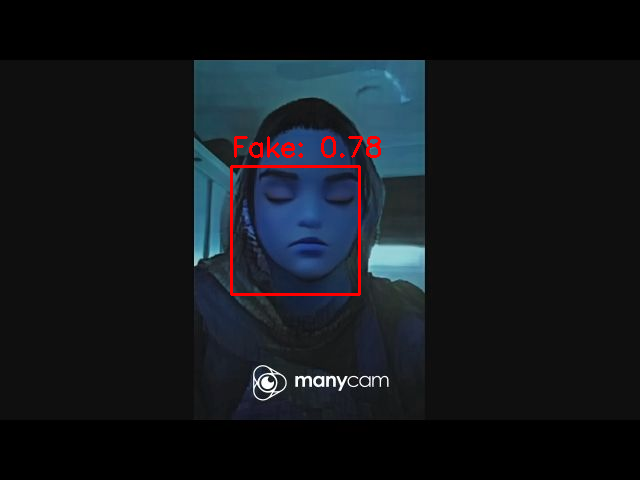

In [20]:
# Initialize Mediapipe face detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Load a pre-trained Xception model (without the top classification layer)
feature_extractor = Xception(weights='imagenet', include_top=False, pooling='avg')

def extract_features(frame):
    """
    Extracts a feature vector from a raw frame using a pre-trained Xception model.
    Args:
        frame: Tensor of shape (224, 224, 3).
    Returns:
        A feature vector of shape (2048,).
    """
    # Preprocess the frame (resize, normalize, etc.)
    frame = tf.image.resize(frame, (299, 299))  # Xception expects (299, 299, 3)
    frame = preprocess_input(frame)  # Normalize for Xception
    frame = tf.expand_dims(frame, axis=0)  # Add batch dimension: (1, 299, 299, 3)

    # Extract features
    features = feature_extractor(frame)  # Shape: (1, 2048)
    return tf.squeeze(features, axis=0)  # Remove batch dimension: (2048,)

# Main script
print("Starting to automatically capture frames from the webcam...")
try:
    # Automatically capture 30 frames at 1-second intervals
    frame_files = take_photos_auto(num_frames=30, interval=1)
    print(f"Total frames captured: {len(frame_files)}")

    # Load the captured frames and ensure they are in RGB format
    frames = []
    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            print(f"Warning: Failed to load image {frame_file}. Skipping this frame.")
            continue
        # Ensure the image is in RGB format (OpenCV loads images in BGR by default)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)

    # Debugging: Check frame shapes and dtypes
    for i, frame in enumerate(frames):
        if frame is None:
            print(f"Frame {i} is None or corrupted.")
        else:
            print(f"Frame {i} shape: {frame.shape}, dtype: {frame.dtype}")

    print(f"Total frames loaded: {len(frames)}")

    # Check if any frames were loaded
    if len(frames) == 0:
        print("No valid frames were loaded. Exiting.")
        exit()

    # Initialize Mediapipe face detection
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
        # Extract face regions from all frames
        face_frames = []
        for i, frame in enumerate(frames):
            # Convert the frame to RGB (Mediapipe requires RGB input)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Perform face detection
            results = face_detection.process(frame_rgb)

            # Debugging: Check number of faces detected
            if results.detections:
                print(f"Frame {i}: Number of faces detected: {len(results.detections)}")
            else:
                print(f"Frame {i}: No faces detected.")
                continue

            # Assume only one face is detected
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            x = int(bboxC.xmin * iw)
            y = int(bboxC.ymin * ih)
            w = int(bboxC.width * iw)
            h = int(bboxC.height * ih)

            # Adjust coordinates if they are out of bounds
            x = max(0, x)
            y = max(0, y)
            w = min(iw - x, w)
            h = min(ih - y, h)

            # Extract the face region
            face_frame = frame[y:y+h, x:x+w]
            if face_frame.size == 0:
                print(f"Warning: Face frame {i} is invalid. Skipping this frame.")
                continue

            # Resize the face frame to (224, 224) for model input
            face_frame = cv2.resize(face_frame, (224, 224))
            face_frames.append(face_frame)

        # Check if any face frames were extracted
        if len(face_frames) == 0:
            print("No valid face frames were extracted. Exiting.")
            exit()

        # Preprocess the face frames
        preprocessed_frames = preprocess_frames(face_frames)
        print("Frames preprocessed for model input.")

        # Debugging: Check preprocessed frames shape and dtype
        print(f"Preprocessed frames shape: {preprocessed_frames.shape}, dtype: {preprocessed_frames.dtype}")

        # Extract spatial features using the Xception model
        spatial_features = []
        for face_frame in face_frames:
            # Convert the face frame to a TensorFlow tensor
            face_frame_tensor = tf.convert_to_tensor(face_frame, dtype=tf.float32)

            # Extract spatial features
            spatial_feature = extract_features(face_frame_tensor)
            spatial_features.append(spatial_feature)

        # Stack spatial features into a single array
        spatial_features = np.stack(spatial_features, axis=0)
        spatial_features = np.mean(spatial_features, axis=0)  # Average over time (if needed)
        print(f"Spatial features shape: {spatial_features.shape}")

        # Prepare inputs for the DeepFakeDetectionModel
        spatial_input = np.expand_dims(spatial_features, axis=0)  # Shape: (1, 2048)
        temporal_input = preprocessed_frames  # Shape: (1, 30, 224, 224, 3)

        # Make prediction
        prediction = model.predict([spatial_input, temporal_input])
        confidence_score = prediction[0][0]
        print(f"Prediction confidence score: {confidence_score:.2f}")

        # Determine the label and color based on the confidence score
        if confidence_score > 0.5:
            label = "Fake"
            color = (0, 0, 255)  # Red for fake
        else:
            label = "Real"
            color = (0, 255, 0)  # Green for real

        # Display the result on the first frame
        cv2.rectangle(frames[0], (x, y), (x + w, y + h), color, 2)
        cv2.putText(frames[0], f"{label}: {confidence_score:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Display the resulting frame using cv2_imshow
        cv2_imshow(frames[0])

except Exception as e:
    print(f"An error occurred: {e}")